# ResNet50 Transfer Model  

In [1]:
EPOCHS=30
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 64
## This veriable just to keep track of run and saved databases.
V='RUN1'

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import *
import pandas as pd
from shutil import copyfile
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import re
import seaborn as sns
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import tensorflow.experimental.numpy as tnp
from sklearn.model_selection import train_test_split
import progressbar as pb
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [3]:
## Tensorflow version and gpu availability check ##
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

2.4.1
Num GPUs Available:  1
Wed Jun  9 18:56:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 20%   34C    P8    N/A /  N/A |     11MiB / 12036MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                               

# One Cycle Training

In [4]:
"""
https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/
"""
from tensorflow.keras.callbacks import Callback

class CosineAnnealer:
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps),
                        CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                       [CosineAnnealer(lr_max, final_lr, phase_2_steps), 
                        CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

# Learning Rate Finder

In [5]:
"""
https://github.com/surmenok/keras_lr_finder/blob/master/keras_lr_finder/lr_finder.py
"""

from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit(generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

# Function for Validation quality measurement

In [63]:
def model_quality(model, dataset):
    length_dataset=len(dataset)
    cm=np.zeros([2,2],dtype=int)
    Pred=[]
    Actu=[]
    
    widgets = ['Progress: ', pb.Percentage(), ' ', 
            pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widgets, maxval=length_dataset).start()
    
    for i in range(length_dataset):
        x=dataset[i]
        y_pred=tf.argmax(model.predict(x[0]),axis=1).numpy()
        Y_pred=x[1].argmax(axis=1)
        cm = cm + confusion_matrix(Y_pred, y_pred,labels=[0,1])
        Pred=np.append(Pred,y_pred)
        Actu=np.append(Actu,Y_pred)
        timer.update(i)
        
    timer.finish()
    tn, fp, fn, tp = cm.ravel()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score=(2*precision*recall)/(recall+precision)
    accuracy = (tp + tn)/(tp + fp + tn + fn) 
    ra_score=roc_auc_score(Actu,Pred)
    
    print("Recall of the model is {}".format(recall))
    print("Precision of the model is {}".format(precision))
    print("F1 score of the model is {}".format(f1_score))
    print("Accuracy of the model is {}".format(accuracy))
    print("ROC AUC Score of the model is {}".format(ra_score))
    print("Here is the confusino matrix")
    
    cm_plt=sns.heatmap(cm/np.sum(cm), fmt='.2%' , annot=True, cmap='Blues', square=True, cbar=False, annot_kws={'size':20} )

# Function for test time augmentation report

In [66]:
def test_augmentation(model, dataset):
    length_dataset=len(dataset)
    Pred=[]
    Actu=[]
    
    widgets = ['Test Time Augmentation Progress: ', pb.Percentage(), ' ', 
            pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widgets, maxval=length_dataset).start()
    
    for i in range(length_dataset):
        x=dataset[i]
        y_pred1 = tf.argmax(model.predict(x[0]),axis=1).numpy()
        x=dataset[i]
        y_pred2 = tf.argmax(model.predict(x[0]),axis=1).numpy()
        x=dataset[i]
        y_pred3 = tf.argmax(model.predict(x[0]),axis=1).numpy()
        x=dataset[i]
        y_pred4 = tf.argmax(model.predict(x[0]),axis=1).numpy()
        x=dataset[i]
        y_pred5 = tf.argmax(model.predict(x[0]),axis=1).numpy()
    
        y_pred = y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5
        np.putmask(y_pred,y_pred <=2,0)
        np.putmask(y_pred,y_pred >2,1)
        
        Y_pred=x[1].argmax(axis=1)
        Pred=np.append(Pred,y_pred)
        Actu=np.append(Actu,Y_pred)
        timer.update(i)
    
    timer.finish()
    cm = confusion_matrix(Actu, Pred,labels=[0,1])
    
    tn, fp, fn, tp = cm.ravel()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score=(2*precision*recall)/(recall+precision)
    accuracy = (tp + tn)/(tp + fp + tn + fn) 
    ra_score=roc_auc_score(Actu,Pred)
    
    print("Recall of the model is {}".format(recall))
    print("Precision of the model is {}".format(precision))
    print("F1 score of the model is {}".format(f1_score))
    print("Accuracy of the model is {}".format(accuracy))
    print("ROC AUC Score of the model is {}".format(ra_score))
    print("Here is the confusino matrix")
    
    cm_plt=sns.heatmap(cm/np.sum(cm), fmt='.2%' , annot=True, cmap='Blues', square=True, cbar=False, annot_kws={'size':25} )

# Function to add noise and rotation to the image data

In [8]:
def add_noise_rotate(img_array):
    noise = np.random.randint(-5,6, img_array.shape)
    noise = noise 
    img = img_array + noise
    np.putmask(img, img < 0, 0)
    np.putmask(img, img > 255, 255)
    rot_angle = np.random.randint(0,4)
    img = np.rot90(img, rot_angle)
    return img

def add_rotate(img_array):
    img = img_array
    np.putmask(img, img < 0, 0)
    np.putmask(img, img > 255, 255)
    rot_angle = np.random.randint(0,4)
    img = np.rot90(img, rot_angle)
    return img

# Load the data and divide it in Train, Validation & Test data

In [9]:
## Consider the extracted data is available in the current directory ##

data_base_dir='.'
train_csv=data_base_dir+'/train_labels.csv'
test_csv=data_base_dir+'/sample_submission.csv'

traindf=pd.read_csv(train_csv,dtype=str)
testdf=pd.read_csv(test_csv,dtype=str)

def append_ext(fn):
    return fn+".tif"

traindf["id"]=traindf["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)

train_df,val_df1=train_test_split(traindf,test_size=0.3,random_state=42,stratify=traindf['label'])
val_df,test_df=train_test_split(val_df1,test_size=0.33,random_state=42,stratify=val_df1['label'])

# ImageDataGenerator is used for Data Augmentation

In [10]:
data_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True, 
                                    preprocessing_function=add_noise_rotate
                                   )

In [68]:
train_dataset=data_generator.flow_from_dataframe(
dataframe=train_df,
directory='{}/train/'.format(data_base_dir),
x_col="id",
y_col="label",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=IMG_SIZE
)

validation_dataset=data_generator.flow_from_dataframe(
dataframe=val_df,
directory='{}/train/'.format(data_base_dir),
x_col="id",
y_col="label",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=IMG_SIZE
)

test_dataset=data_generator.flow_from_dataframe(
dataframe=test_df,
directory='{}/train/'.format(data_base_dir),
x_col="id",
y_col="label",
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=IMG_SIZE
)

Found 154017 validated image filenames belonging to 2 classes.
Found 44225 validated image filenames belonging to 2 classes.
Found 21783 validated image filenames belonging to 2 classes.


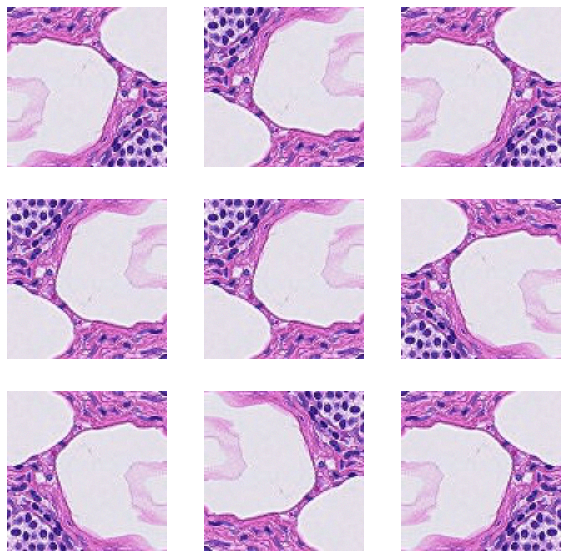

In [12]:
first_image = train_dataset[0][0][0]
plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 3, 1)
plt.imshow(first_image.astype("uint8"))
plt.axis("off")

for i in np.arange(2,10).tolist():
    ax = plt.subplot(3,3,i)
    plt.imshow(data_generator.random_transform(first_image).astype("uint8"))
    plt.axis("off")

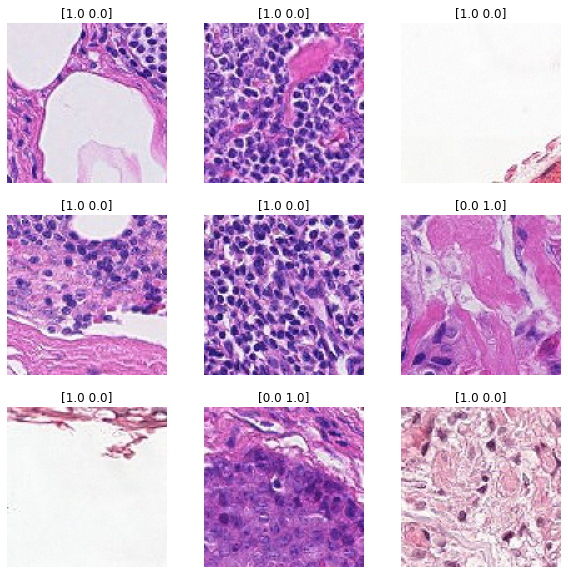

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_dataset[0][0][i].astype("uint8"))
    plt.title('[{} {}]'.format(train_dataset[0][1][i][0],train_dataset[0][1][i][1]))
    plt.axis("off")

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.resnet50.preprocess_input
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 2048)


In [17]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
#x = data_augmentation(inputs)
#x = preprocess_input(x)
x = preprocess_input(inputs)
x = base_model(x, training=False)
avgpool = tf.keras.layers.AveragePooling2D((3,3), padding="same")(x)
maxpool = tf.keras.layers.MaxPooling2D((3,3), padding="same")(x)
x = tf.keras.layers.Concatenate()([avgpool, maxpool])
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(2,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 224, 224, 3)  0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    tf.nn.bias_add[0][0]             
______________________________________________________________________________________________

In [25]:
## Updated the learning rate based on the learning rate found by lr_finder ##
used_metrics='categorical_accuracy'
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[used_metrics])

In [21]:
loss0, accuracy0 = model.evaluate(validation_dataset)

692/692 [==============================] - 221s 316ms/step - loss: 1.0387 - categorical_accuracy: 0.5484


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.03
initial accuracy: 0.55


In [23]:
lr_finder = LRFinder(model)
lr_finder.find_generator(train_dataset, start_lr=0.000001, end_lr=1, epochs=3)

Epoch 1/3
2407/2407 [==============================] - 885s 366ms/step - loss: 0.6010 - categorical_accuracy: 0.7881
Epoch 2/3
2407/2407 [==============================] - 1120s 465ms/step - loss: 0.3630 - categorical_accuracy: 0.8538
Epoch 3/3
2407/2407 [==============================] - 540s 224ms/step - loss: 1.1073 - categorical_accuracy: 0.8204


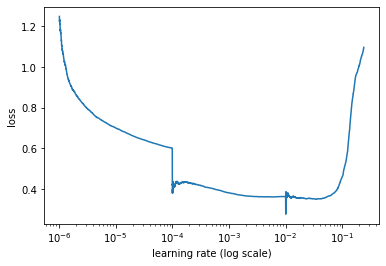

Best learning rate:  9.999989e-05


In [24]:
lr_finder.plot_loss()
print("Best learning rate: ",lr_finder.get_best_lr(1))

In [ ]:
## This is for One Cycle Policy ##
epochs = EPOCHS
lr=0.01
STEP_SIZE_TRAIN=len(train_dataset)
steps = STEP_SIZE_TRAIN * epochs
lr_schedule = OneCycleScheduler(lr, steps,div_factor=100)

In [28]:
## This is For Reduced learning rate platue ##
lr_schedule = ReduceLROnPlateau(monitor='val_'+used_metrics, factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.0001)

In [29]:
initial_epochs = EPOCHS
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[lr_schedule]
                   )

Epoch 1/30
2407/2407 [==============================] - 1065s 436ms/step - loss: 0.4321 - categorical_accuracy: 0.8329 - val_loss: 0.3229 - val_categorical_accuracy: 0.8623
Epoch 2/30
2407/2407 [==============================] - 1028s 427ms/step - loss: 0.2977 - categorical_accuracy: 0.8748 - val_loss: 0.2596 - val_categorical_accuracy: 0.8931
Epoch 3/30
2407/2407 [==============================] - 991s 412ms/step - loss: 0.2920 - categorical_accuracy: 0.8797 - val_loss: 0.2601 - val_categorical_accuracy: 0.8928
Epoch 4/30
2407/2407 [==============================] - 996s 414ms/step - loss: 0.2855 - categorical_accuracy: 0.8826 - val_loss: 0.2533 - val_categorical_accuracy: 0.8979
Epoch 5/30
2407/2407 [==============================] - 984s 409ms/step - loss: 0.2790 - categorical_accuracy: 0.8842 - val_loss: 0.2572 - val_categorical_accuracy: 0.8924
Epoch 6/30
2407/2407 [==============================] - 1012s 421ms/step - loss: 0.2744 - categorical_accuracy: 0.8870 - val_loss: 0.2567 

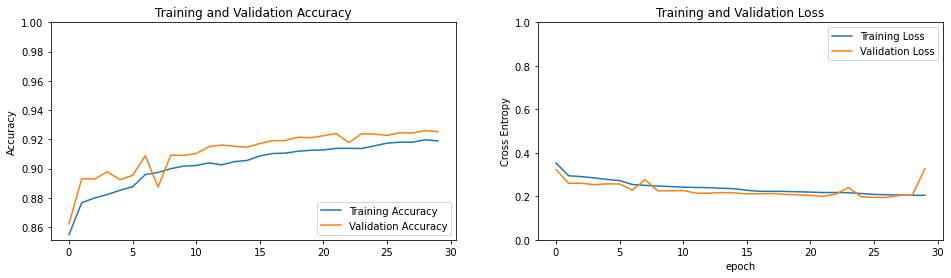

In [30]:
acc = history.history[used_metrics]
val_acc = history.history['val_'+used_metrics]

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
!mkdir -p model
model.save('model/pre_fine_tune_model_{}'.format(V))

INFO:tensorflow:Assets written to: model/pre_fine_tune_model_RUN1/assets


Recall of the model is 0.8980013398838768
Precision of the model is 0.9173605566328277
F1 score of the model is 0.9075777238616487
Accuracy of the model is 0.9259242509892595
ROC AUC Score of the model is 0.9214667513465673
Here is the confusino matrix


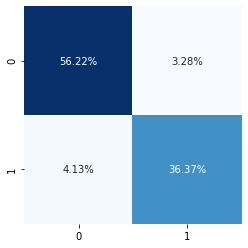

In [32]:
model_quality(model, validation_dataset)

In [42]:
model=tf.keras.models.load_model('model/pre_fine_tune_model_RUN1')

In [46]:
base_model = model.layers[3]

In [47]:
base_model.trainable = True

In [48]:
import re
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
## Freeze all batch normalization layers.
for layer in base_model.layers[fine_tune_at:]:
    layer_name=type(layer).__name__
    if re.match('BatchNormalization',layer_name):
        layer.trainable =  False

Number of layers in the base model:  175


In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 224, 224, 3)  0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    tf.nn.bias_add[0][0]             
______________________________________________________________________________________________

In [50]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005),
              metrics=[used_metrics])

In [37]:
lr_finder = LRFinder(model)
lr_finder.find_generator(train_dataset, start_lr=0.000001, end_lr=1, epochs=3)

Epoch 1/3
2407/2407 [==============================] - 890s 367ms/step - loss: 0.2015 - categorical_accuracy: 0.9219
Epoch 2/3
2407/2407 [==============================] - 801s 333ms/step - loss: 0.2908 - categorical_accuracy: 0.8812
Epoch 3/3
2407/2407 [==============================] - 272s 113ms/step - loss: 0.7136 - categorical_accuracy: 0.5565


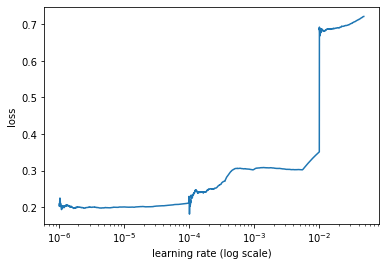

Best learning rate:  0.0001001914


In [38]:
lr_finder.plot_loss()
print("Best learning rate: ",lr_finder.get_best_lr(1))

In [30]:
epochs = EPOCHS + 1
lr=0.0001
STEP_SIZE_TRAIN=len(train_dataset)
steps = STEP_SIZE_TRAIN * epochs
lr_schedule = OneCycleScheduler(lr, steps,div_factor=10)

In [51]:
## This is For Reduced learning rate platue ##
lr_schedule = ReduceLROnPlateau(monitor='val_'+used_metrics, factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.000005)

In [52]:
fine_tune_epochs = EPOCHS
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[lr_schedule]
                        )

Epoch 30/60
2407/2407 [==============================] - 1145s 474ms/step - loss: 0.2470 - categorical_accuracy: 0.9063 - val_loss: 0.2939 - val_categorical_accuracy: 0.8910
Epoch 31/60
2407/2407 [==============================] - 1035s 430ms/step - loss: 0.1666 - categorical_accuracy: 0.9390 - val_loss: 0.1564 - val_categorical_accuracy: 0.9425
Epoch 32/60
2407/2407 [==============================] - 1058s 439ms/step - loss: 0.1505 - categorical_accuracy: 0.9462 - val_loss: 0.1416 - val_categorical_accuracy: 0.9500
Epoch 33/60
2407/2407 [==============================] - 1039s 432ms/step - loss: 0.1318 - categorical_accuracy: 0.9532 - val_loss: 0.1249 - val_categorical_accuracy: 0.9558
Epoch 34/60
2407/2407 [==============================] - 1083s 450ms/step - loss: 0.1848 - categorical_accuracy: 0.9314 - val_loss: 0.1732 - val_categorical_accuracy: 0.9326
Epoch 35/60
2407/2407 [==============================] - 1179s 490ms/step - loss: 0.1291 - categorical_accuracy: 0.9551 - val_loss

In [53]:
acc += history_fine.history[used_metrics]
val_acc += history_fine.history['val_'+used_metrics]

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

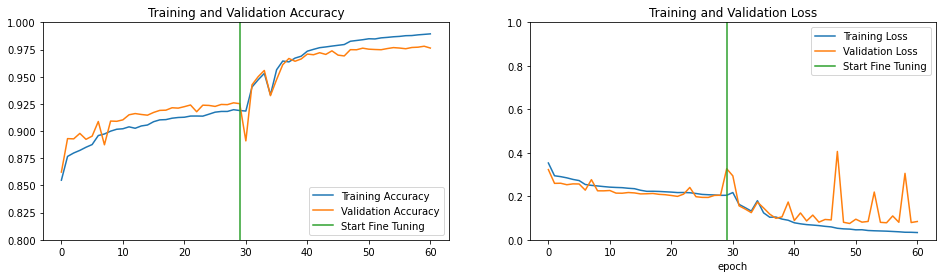

In [54]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
!mkdir -p model
model.save('model/model_tf{}'.format(V))

INFO:tensorflow:Assets written to: model/model_tfRUN1/assets


Progress: 100% |||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:06:04


Recall of the model is 0.9686802143814203
Precision of the model is 0.9723171756794621
F1 score of the model is 0.9704952876359874
Accuracy of the model is 0.9761447145279819
ROC AUC Score of the model is 0.9749531121692379
Here is the confusino matrix


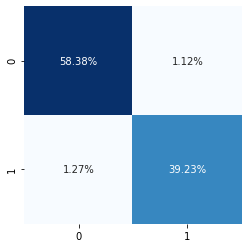

In [56]:
test_augmentation(model, test_dataset)

Test Time Augmentation Progress: 100% ||||||||||||||||||||||||||| Time: 0:11:24


Recall of the model is 0.9784653745891421
Precision of the model is 0.9771363893604981
F1 score of the model is 0.9778004303998188
Accuracy of the model is 0.9820043152917413
ROC AUC Score of the model is 0.9814394774180278
Here is the confusino matrix


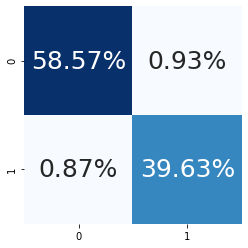

In [69]:
test_augmentation(model, test_dataset)

Recall of the model is 0.9695734702992407
Precision of the model is 0.9721242653232578
F1 score of the model is 0.970847192330268
Accuracy of the model is 0.976416054267948
ROC AUC Score of the model is 0.975323732071294
Here is the confusino matrix


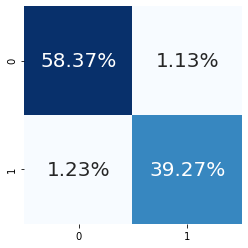

In [64]:
model_quality(model, validation_dataset)

Recall of the model is 0.9887146933410279
Precision of the model is 0.9880336403684421
F1 score of the model is 0.9883740495324781
Accuracy of the model is 0.9905789620626294
ROC AUC Score of the model is 0.990281393159301
Here is the confusino matrix


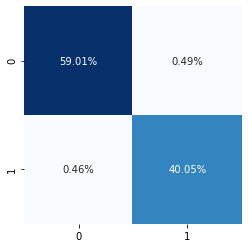

In [60]:
model_quality(model, train_dataset)

In [61]:
def remove_ext(fn):
    return fn.replace('.tif','')

datagen = ImageDataGenerator()

test_dataset=datagen.flow_from_dataframe(
    dataframe=testdf,
    directory='{}/test/'.format(data_base_dir),
    x_col="id",
    y_col=None,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMG_SIZE
    )

y_pred=model.predict(test_dataset,verbose=1)
testdf['label']=np.argmax(y_pred,axis=1)


testdf["id"]=testdf["id"].apply(remove_ext)
#testdf.to_csv(data_base_dir+'/new_submission.csv',index=False)
display(testdf)

Found 57458 validated image filenames.
898/898 [==============================] - 1081s 1s/step


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0
57454,6f3977130212641fd5808210015a609c658dcbff,0
57455,46935f247278539eca74b54d07d666efb528a753,0
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0
